In [1]:
import torch
from torch import nn

import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange

import model
from data import seq_data
from visualization import hidden_repr

# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [2]:
## Instantiate model
model = model.Model(
    input_size=1,
    output_size=1,
    hidden_dim=10,
    n_layers=2,
    device=device,
    # output_noise=0.01,
)

## Generate data
xor_problem = lambda seq: np.sum(seq) % 2
problem = xor_problem
symbols = {0, 1}

train_datasets = [
    seq_data(device, symbols, problem, seq_len=1),
    seq_data(device, symbols, problem, seq_len=2),
    seq_data(device, symbols, problem, seq_len=3),
    seq_data(device, symbols, problem, seq_len=4),
]

val_datasets = [
    seq_data(device, symbols, problem, n_datapoints=10, seq_len=10),
    seq_data(device, symbols, problem, seq_len=1),
    seq_data(device, symbols, problem, seq_len=2),
    seq_data(device, symbols, problem, seq_len=3),
    seq_data(device, symbols, problem, seq_len=4),
]

In [3]:
## Train

# Define hyperparameters
n_epochs = 1000
lr = 0.01

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training run
train_losses, val_losses, hidden_states = model.training_run(
    optimizer,
    criterion,
    train_datasets,
    val_datasets,
    n_epochs=n_epochs,
    batch_size=1000,
)

Training: 100%|██████████| 1000/1000 [00:31<00:00, 32.25steps/s, train_loss=0.00001, val_loss=0.04878]


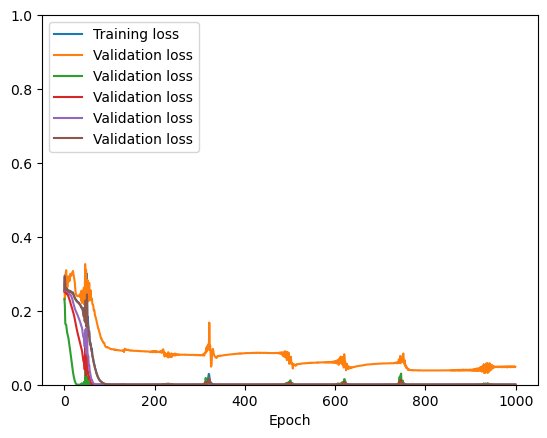

In [4]:
## Plot training and validation loss during training
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend(loc="upper left")
plt.xlabel("Epoch")
plt.ylim(0, 1)
plt.show()

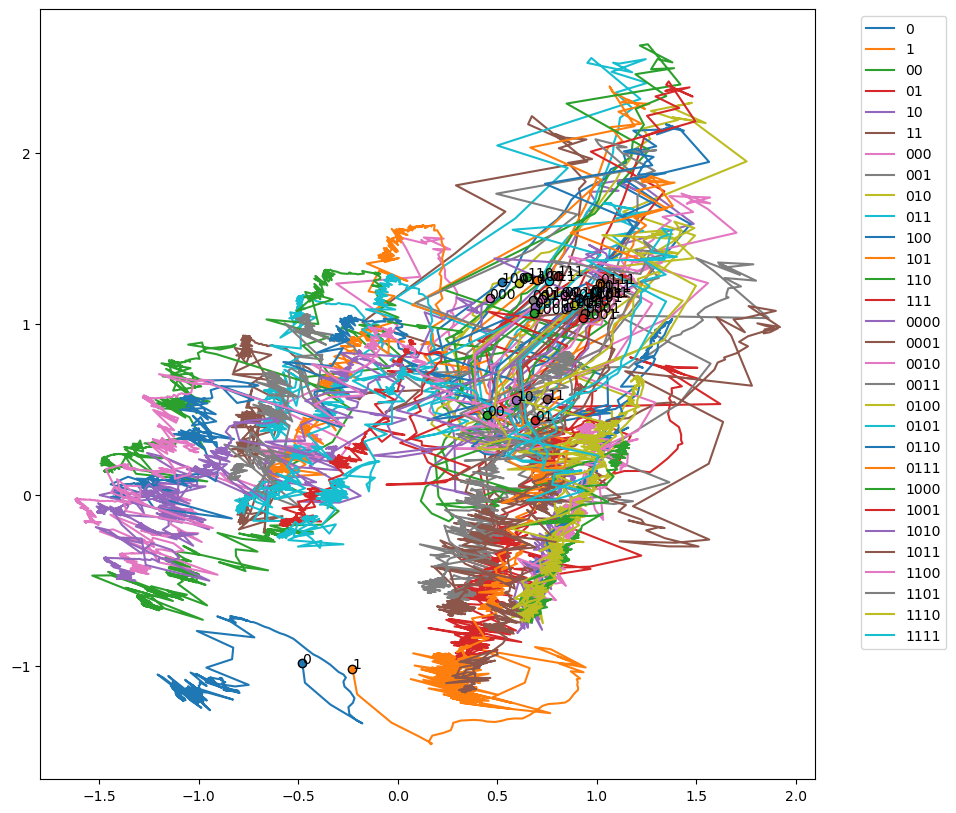

interactive(children=(IntSlider(value=0, description='Epoch:', layout=Layout(width='70%'), max=999), Output())…

In [5]:
## Show evolution of hidden states
data = hidden_states
# data = data.query(f"Epoch >= 0")
data = data.query(f"Dataset == 1 or Dataset == 2 or Dataset == 3 or Dataset == 4")
# data = data.query(f"Dataset == 0")

hidden_repr(data, transform="PCA", n_labels=0, fig_size=10)
# TODO plot output values at each point
# TODO Plot map A(h)

100%|██████████| 100/100 [00:00<00:00, 249.95it/s]


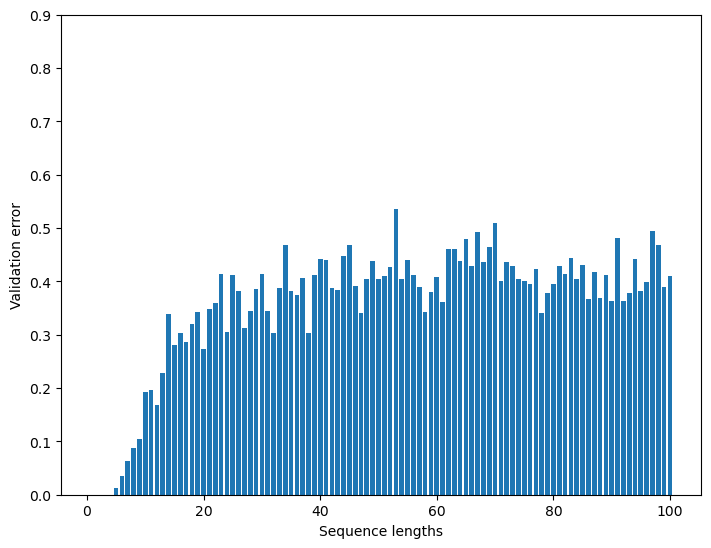

In [6]:
## Plot error per sequence length
N = 100
val_data = []
for n in trange(1, N + 1):
    val_data.append(seq_data(device, symbols, problem, n_datapoints=100, seq_len=n))
val_err = np.array(model.validation(criterion, val_data))

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(np.arange(1, N + 1), val_err)
ax.set_xlabel("Sequence lengths")
ax.set_ylabel("Validation error")
ax.set_yticks(np.arange(0, 1, 0.1))
plt.show()

In [7]:
def predict(model, sequence):
    input = torch.unsqueeze(
        torch.from_numpy(np.array([sequence], dtype=np.float32)), dim=2
    ).to(device)
    out, hidden = model(input)
    return out


x = [1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
print(f"Prediction: {float(predict(model, x))}, True output: {problem(x)}")

Prediction: 0.0, True output: 1
